In [5]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import math

The single arm source model is an extension of the single arm source mode described in detail in the IJP paper:
"Theoretical and numerical investigations of single arm dislocation source controlled plastic flow in FCC micropillars" https://doi.org/10.1016/j.ijplas.2013.11.011


## 1. Assign initial conditions (material parameters)

In [6]:
alpha = 0.5 #parameter in equation 5
k= 1.0      #parameter in equation 5
B = 2.0e-5 #drag coefficient [Pa.s]
mu = 48e9   # shear modulus [Pa]
b =   0.256e-9     # Burger's vector [m]
nu =0.34          # poisson's ratio 
beta=np.arccos(1/np.sqrt(3)) #angle between slip plane normal (111) and loading axis (001)
modulus=mu*2*(1+nu)
M= 0.4082 

D = 250e-9 #[m]
H = 2 * D  
V =  H * D ** 2              # sample volume [m^3]



## 2. Calculate the number of stable SAS n

In [7]:
def num_SAS(rho,D,H):
    return math.ceil(np.pi*rho*D*H/4)

## 3.Calculate the dislocation density (equation (7) of the manuscript)

In [8]:
kf=0.01 #dimentionless constant 
ka=7e-10 #[m] a quantity that is proportional to the critical annihilation distance for screw dislocations
def density_evolution(lamada,density,delta_gamma):  #equation (5) of the IJP paper.
    density_incr=(0.5/b/lamada-2*np.cos(beta/2)**2/b/D+kf/b*np.sqrt(density)-ka/b*density)*delta_gamma
    return density_incr

## 4. Calculate the effective source length $\lambda$ (equation 7 and 8 of the paper: https://doi.org/10.1016/j.ijplas.2013.11.011)

In [9]:
def effective_SAS_length(num):
    radius=D/2
    r=1.0
    bb=1/np.cos(beta)
    function = lambda x: x*(1-(r-x)*(bb-x)/r/bb)**(num-1)*(r+bb-2*x)/r/bb*num
    value, err= integrate.quad(function, 0, r)
    return value*radius

## 5. Calculate the stress 

In [10]:
def static_tau(rho,lamda):
    tau_zero=0.0 #lattice friction, zero here for copper.
    Taylor_term=alpha*mu*b*np.sqrt(rho)
    line_tension=k*mu*b/lamda
    return tau_zero+Taylor_term+line_tension

def rate_tau(epsilondot,lamda,n):
    return 2*B*epsilondot*V/M/b**2/lamda/n

density needed= 4.14e+12 [m-2]
number of SAS needed: 1
stable density= 4.32e+13 [m-2]
stable SASnumber= 5.00e+00
yield stress = 523.230 [MPa]


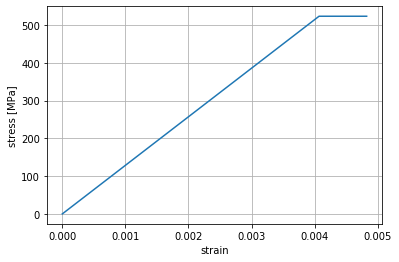

In [11]:
epsilondot=1e6
vmax=2313.984 #[m/s]
rhoneeded=epsilondot/vmax/b/M
print(f"density needed= {rhoneeded:.2e} [m-2]")
numneeded=num_SAS(rhoneeded,D,H)
print('number of SAS needed:',numneeded)
totalincrements=10000
target_plasticstrain=0.002
delta_epsilonp=target_plasticstrain/totalincrements
stress=np.zeros(totalincrements)
strain=np.zeros(totalincrements)
density=np.zeros(totalincrements)
pinnum=np.zeros(totalincrements)
lamada_s=np.zeros(totalincrements)
lamada_c=np.zeros(totalincrements)

density[0]=5e13 #initial dislocation density 
pinnum[0]=num_SAS(density[0],D,H)
lamada_s[0]=effective_SAS_length(pinnum[0])

for i in np.arange(1,totalincrements,1):
    ddensity=density_evolution(lamada_s[i-1],density[i-1],delta_epsilonp)
    density[i]=ddensity+density[i-1]

    if density[i] <=0 :
        print('no density')
        break
    pinnum[i]=num_SAS(density[i],D,H)
    if pinnum[i] <=1 :
        pinnum[i]=1
    lamada_s[i]=effective_SAS_length(pinnum[i])
    lamada_c[i]=D

    rate_effect=rate_tau(epsilondot,lamada_c[i],pinnum[i])
    stress[i]=(static_tau(density[i],lamada_s[i])+rate_effect)/M
    strain[i]=stress[i]/modulus+delta_epsilonp*i*M
    if stress[i] <= stress[i-1]:
        stress[i]=stress[i-1]
print(f"stable density= {density[i]:.2e} [m-2]")    
print(f"stable SASnumber= {pinnum[i]:.2e}")  
fig, ax = plt.subplots()
ax.plot(strain[:i], stress[:i] * 1e-6,'-')
ax.set(xlabel='strain', ylabel="stress [MPa]");
ax.grid(True)
print(f"yield stress = {stress.max() * 1e-6:5.3f} [MPa]")    